In [ ]:
#| default_exp nb_01_graphs

In [ ]:
import pandas as pd
from imutils import contours
from skimage import measure
import numpy as np
import argparse
import imutils
import cv2
import matplotlib.pyplot as plt
from skimage.future import graph
from scipy.spatial import cKDTree
from functools import partial
from matplotlib import pyplot

In [ ]:
df = pd.read_pickle("data/df_all_2022_10_06.pkl")
df.shape

(1180, 95)

In [ ]:
image_path = str(df["fn_y"][0])
image_path

'/media/dimi/TOSHIBA EXT/Dimitrij Shape Masks/TMA01/12-E.tif'

In [ ]:
image = cv2.imread(image_path, cv2.IMREAD_UNCHANGED)

In [ ]:
image.shape

(5120, 5120)

In [ ]:
image.ndim

2

In [ ]:
len(np.unique(image))

331

In [ ]:
#| export
def show_lattice(img):
    return pd.DataFrame(img).style.set_properties(**{'font-size':'6pt'}).background_gradient('YlOrRd')

In [ ]:
#| export
def label_image(image, min_num_pixels=0):
    '''Label each cell in a TMA uniquely
       image: masked image with cell and nuclei shapes
    '''
    thresh = cv2.threshold(image, 0, 255, cv2.THRESH_BINARY)[1]
    labels = measure.label(thresh, background=0, connectivity=image.ndim)
    mask = np.zeros(thresh.shape, dtype="uint8")

    for label in np.unique(labels): # loop over the unique components
        if label == 0: continue # if this is the background label, ignore it
        label_mask = np.zeros(thresh.shape, dtype="uint8")
        label_mask[labels == label] = label
        mask = cv2.add(mask, label_mask)
    return mask

In [ ]:
#labeled_image = label_image(image)
labeled_image = label_image(img)

In [ ]:
#| export
pd.DataFrame.cols2arr = lambda x: x.apply(lambda c: tuple(c), axis=1).apply(np.array)

In [ ]:
#show_lattice(img)

In [ ]:
def P(im1,im2):
    return measure.perimeter(im1, neighbourhood=8)

In [ ]:
#| export
pars_to_measure = ["label", "bbox", "area", "centroid", "perimeter_crofton", "slice"]
def measure_pars(labeled_image, pars_to_measure = pars_to_measure, extra_measures=None):
    return pd.DataFrame(measure.regionprops_table(label_image=labeled_image,
                                        intensity_image=img,
                                        properties=pars_to_measure, 
                                        extra_properties=extra_measures))

In [ ]:
cells = measure_pars(labeled_image, extra_measures=[P])
cells["cell_shape"] = cells.P/np.sqrt(cells.area) 
cells.head(n=10)

,label,bbox-0,bbox-1,bbox-2,bbox-3,area,centroid-0,centroid-1,perimeter_crofton,slice,P,cell_shape
0,1,0,245,19,269,356,7.632022,256.075843,72.647347,"(slice(0, 19, None), slice(245, 269, None))",82.000000,4.345991
1,2,0,268,14,291,262,5.526718,279.645038,65.713516,"(slice(0, 14, None), slice(268, 291, None))",70.000000,4.324614
2,3,0,291,24,315,413,9.043584,301.292978,77.915096,"(slice(0, 24, None), slice(291, 315, None))",94.000000,4.625438
3,4,0,315,6,333,89,2.146067,323.067416,42.730052,"(slice(0, 6, None), slice(315, 333, None))",43.207107,4.579944
4,5,0,332,30,374,868,12.525346,350.216590,119.859750,"(slice(0, 30, None), slice(332, 374, None))",137.207107,4.657113
5,6,6,299,51,341,1401,29.842256,319.297645,140.526488,"(slice(6, 51, None), slice(299, 341, None))",170.000000,4.541819
6,7,12,261,58,300,1303,33.075979,279.963929,135.068169,"(slice(12, 58, None), slice(261, 300, None))",165.207107,4.576743
7,8,13,241,53,262,567,31.820106,250.620811,98.447081,"(slice(13, 53, None), slice(241, 262, None))",116.414214,4.888937
8,9,31,330,76,383,1656,54.472222,355.525966,159.162354,"(slice(31, 76, None), slice(330, 383, None))",192.000000,4.718143
9,10,39,114,84,161,1228,60.337134,133.777687,143.898118,"(slice(39, 84, None), slice(114, 161, None))",178.414214,5.091319


In [ ]:
get_bbox(9)

array([39, 114, 84, 161], dtype=object)

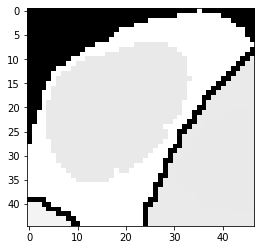

In [ ]:
plt.imshow((img[cells.slice[9]]), cmap="gray");

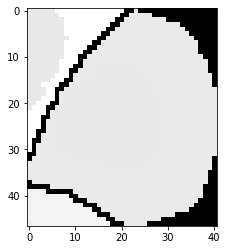

In [ ]:
plt.imshow((img[cells.slice[10]]),cmap="gray");

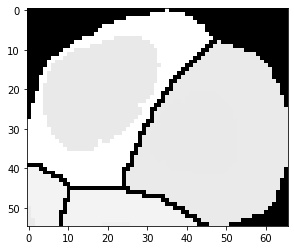

In [ ]:
plt.imshow(img[combine_images(get_bbox(9),get_bbox(10), slicing=True)], cmap="gray");

In [ ]:
def combine_images(bbox1,bbox2, slicing=False):
    xmin = np.min([bbox1[0],bbox1[2],bbox2[0],bbox2[2]])
    xmax = np.max([bbox1[0],bbox1[2],bbox2[0],bbox2[2]])
    ymin = np.min([bbox1[1],bbox1[3],bbox2[1],bbox2[3]])
    ymax = np.max([bbox1[1],bbox1[3],bbox2[1],bbox2[3]])
    if slicing == True:
        return (slice(xmin, xmax, None), slice(ymin, ymax, None))
    else:
        return  np.array([xmin,ymin,xmax,ymax])

In [ ]:
def select_images(i,j):
    ci = combine_images(get_bbox(i),get_bbox(j), slicing=True)
    li = labeled_image[ci].copy()
    m = np.zeros(li.shape, dtype="uint8")
    for l in [i,j]: # loop over the unique components
        l+=1
        lm = np.zeros(li.shape, dtype="uint8")
        lm[li == l] = l
        m = cv2.add(m, lm)
    return m

In [ ]:
np.unique(select_images(9,10))

array([ 0, 10, 11], dtype=uint8)

<matplotlib.image.AxesImage>

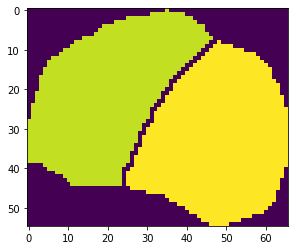

In [ ]:
plt.imshow(select_images(9,10))

In [ ]:
cells.slice[9]

(slice(39, 84, None), slice(114, 161, None))

In [ ]:
cells.slice[10]

(slice(47, 94, None), slice(139, 180, None))

In [ ]:
combine_images(get_bbox(9),get_bbox(10))

array([ 39, 114,  94, 180])

In [ ]:
#| export
def dist(x, num_nn=8):
    '''x.shape: (:,2)'''
    tree = cKDTree(x)
    dists, inds  = tree.query(x, k=(num_nn+1)) #lookup for 8 nn
    dists, inds = dists[:,0:], inds[:,0:] #0 is index of self
    dists, inds = pd.DataFrame(dists), pd.DataFrame(inds)
    #dists, inds = pd.DataFrame(dists).applymap(lambda x: x<max_dist), pd.DataFrame(inds).applymap(lambda x: x<max_dist)    
    return dists.cols2arr(), inds.cols2arr()

In [ ]:
#| export
def overlap2d(bbox1, bbox2):
    b1y1,b1x1,b1y2,b1x2 = bbox1
    b2y1,b2x1,b2y2,b2x2 = bbox2
    dx=1
#     def overlap1d(b1x1,b1x2,b2x1,b2x2): return (b1x2>=b2x1 and b2x2>=b1x1)
    def overlap1d(b1x1,b1x2,b2x1,b2x2): return (b2x1-b1x2)<=dx and (b1x1-b2x2)<=dx
    return overlap1d(b1x1,b1x2,b2x1,b2x2) and overlap1d(b1y1,b1y2,b2y1,b2y2)

def _get_bbox(i,df): return df.loc[i,["bbox-0","bbox-1","bbox-2","bbox-3"]].to_numpy()

In [ ]:
cells = measure_pars(labeled_image)
#cells = cells.set_index("label")

In [ ]:
get_bbox = partial(_get_bbox, df=cells)

def is_overlapping(i,j): return overlap2d(get_bbox(i),get_bbox(j))

In [ ]:
cells["nn_dists"], cells["nn_inds"] = dist(cells[["centroid-0","centroid-1"]])

In [ ]:
cells.head()

,label,bbox-0,bbox-1,bbox-2,bbox-3,area,centroid-0,centroid-1,perimeter_crofton,centroid_weighted-0,centroid_weighted-1,nn_dists,nn_inds
0,1,0,245,19,269,356,7.632022,256.075843,72.647347,7.569098,256.042136,"[0.0, 23.663036236892584, 24.795579116731457, ...","[0, 1, 7, 6, 2, 5, 3, 11, 4]"
1,2,0,268,14,291,262,5.526718,279.645038,65.713516,5.581164,279.665438,"[0.0, 21.931749914093764, 23.663036236892584, ...","[1, 2, 0, 6, 7, 3, 5, 4, 11]"
2,3,0,291,24,315,413,9.043584,301.292978,77.915096,9.060275,301.285002,"[0.0, 21.931749914093764, 22.840793725725153, ...","[2, 1, 3, 5, 6, 0, 4, 7, 11]"
3,4,0,315,6,333,89,2.146067,323.067416,42.730052,2.170288,323.100475,"[0.0, 22.840793725725153, 27.951565447914934, ...","[3, 2, 5, 4, 1, 6, 8, 0, 11]"
4,5,0,332,30,374,868,12.525346,350.216590,119.859750,12.544116,350.226750,"[0.0, 29.06556505735741, 35.43806637857055, 42...","[4, 3, 5, 8, 2, 1, 6, 12, 11]"


In [ ]:
f = lambda x: [True] + list(map(lambda i: is_overlapping(x[0],i),x[1:]))
cells["overlap"] = cells.apply(lambda x: f(x.nn_inds), axis=1)

In [ ]:
f = lambda x,y: x[y]
cells["nnn"] = cells.apply(lambda x: f(x.nn_inds, x.overlap), axis=1)

In [ ]:
cells.head()

,label,bbox-0,bbox-1,bbox-2,bbox-3,area,centroid-0,centroid-1,perimeter_crofton,centroid_weighted-0,centroid_weighted-1,nn_dists,nn_inds,overlap,nnn
0,1,0,245,19,269,356,7.632022,256.075843,72.647347,7.569098,256.042136,"[0.0, 23.663036236892584, 24.795579116731457, ...","[0, 1, 7, 6, 2, 5, 3, 11, 4]","[True, True, True, True, False, False, False, ...","[0, 1, 7, 6]"
1,2,0,268,14,291,262,5.526718,279.645038,65.713516,5.581164,279.665438,"[0.0, 21.931749914093764, 23.663036236892584, ...","[1, 2, 0, 6, 7, 3, 5, 4, 11]","[True, True, True, True, False, False, False, ...","[1, 2, 0, 6]"
2,3,0,291,24,315,413,9.043584,301.292978,77.915096,9.060275,301.285002,"[0.0, 21.931749914093764, 22.840793725725153, ...","[2, 1, 3, 5, 6, 0, 4, 7, 11]","[True, True, True, True, True, False, False, F...","[2, 1, 3, 5, 6]"
3,4,0,315,6,333,89,2.146067,323.067416,42.730052,2.170288,323.100475,"[0.0, 22.840793725725153, 27.951565447914934, ...","[3, 2, 5, 4, 1, 6, 8, 0, 11]","[True, True, True, True, False, False, False, ...","[3, 2, 5, 4]"
4,5,0,332,30,374,868,12.525346,350.216590,119.859750,12.544116,350.226750,"[0.0, 29.06556505735741, 35.43806637857055, 42...","[4, 3, 5, 8, 2, 1, 6, 12, 11]","[True, True, True, True, False, False, False, ...","[4, 3, 5, 8]"


In [ ]:
from matplotlib.patches import Rectangle
import networkx as nx

## Build a graph

In [ ]:
G = nx.Graph()
n_nodes = cells.shape[0]

for idx in range(n_nodes):
    G.add_node(idx, 
                   pos=cells.loc[idx,["centroid-1","centroid-0"]].to_list()
                  )

In [ ]:
for i in range(n_nodes):
    x = cells.loc[i,"nnn"]
    G.add_edges_from([(x[0],i) for i in x[1:]])

In [ ]:
G.number_of_edges()

118

In [ ]:
G.number_of_nodes()

64

In [ ]:
list(G.neighbors(0))

[1, 7, 6]

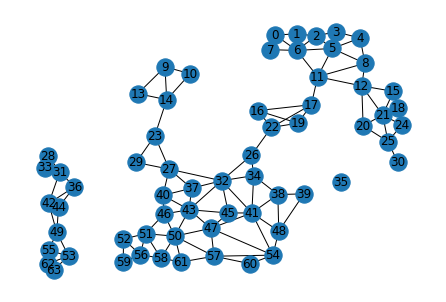

In [ ]:
nx.draw(G, nx.get_node_attributes(G, 'pos'), with_labels=True, #font_weight='bold'
       )
pyplot.gca().invert_yaxis()
#pyplot.gca().invert_xaxis()

In [ ]:
get_bbox(9)

array([39, 114, 84, 161], dtype=object)

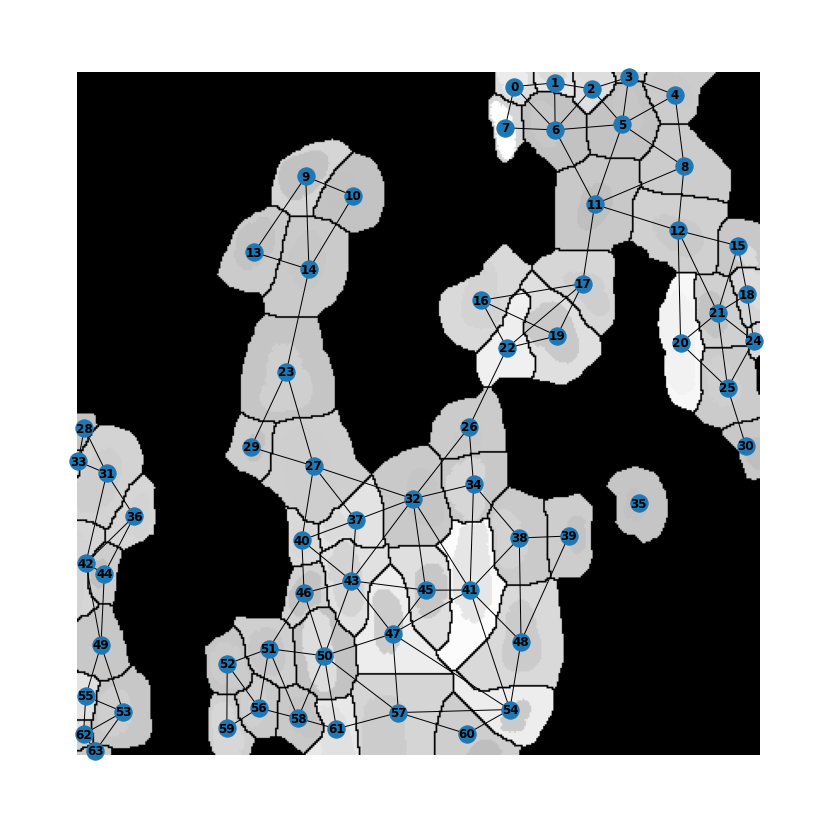

In [ ]:
#n=10
#y1,x1,y2,x2= get_bbox(n)
#dx = int(x2-x1)
#dy = int(y2-y1)
#y11,x11,y12,x12= get_bbox(14)
#dx1 = int(x12-x11)
#dy1 = int(y12-y11)

dx=200
img = image[3000-dx:3000+dx,3800-dx:3800+dx]
plt.figure(figsize=(15,15));
plt.imshow(img, cmap="gray");
#plt.gca().add_patch(Rectangle((x1,y1),dx,dy,linewidth=2,edgecolor='r',facecolor='none'));
#plt.gca().add_patch(Rectangle((x11,y11),dx1,dy1,linewidth=2,edgecolor='r',facecolor='none'));

nx.draw(G, nx.get_node_attributes(G, 'pos'), with_labels=True, 
font_weight='bold'       )
#plt.gca().invert_yaxis()